<a href="https://colab.research.google.com/github/ClaudinusT/Speech-Recognition/blob/main/HateSpeech_Model_SourceCode_2201730740.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NAME: Tonto Claudinus
# NIM: 2201730740
# CLASS: LA01
# Code - Course : COM6588 – Information Retrieval
# FINAL EXAM - Information Retrieval (HATE SPEECH MODEL)

### *note: 
### 1. Jika ingin melakukan training ulang, saya anjurkan untuk menggunakan google colab dengan runtime type menggunakan GPU untuk proses training yang lebih cepat.

### 2. Untuk analisa dari cross-inferencing dijelaskan pada column terakhir dari source code ini

In [ ]:
!pip install Sastrawi

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import string
from collections import Counter
from nltk.stem import PorterStemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

## Speech Classification with Hate Speech Dataset

## Load Dataset Hate Speech Dataset

In [ ]:
# load dataset
dataset = pd.read_csv('hatespeech.txt', sep='\t+')

text = dataset['Tweet']
dataset['Label'] = (dataset['Label'] == 'Non_HS').astype('int')

dataset.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,Label,Tweet
0,1,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...
1,1,RT @baguscondromowo: Mereka terus melukai aksi...
2,1,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,1,"""Ahmad Dhani Tak Puas Debat Pilkada, Masalah J..."
4,1,RT @lisdaulay28: Waspada KTP palsu.....kawal P...


## Text Pre-Processing

In [ ]:
def SpeechPreprocess(phrase):
    
    # Remove Indonesian stopwords
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()
    stop = stopword.remove(phrase)

    # Remove punctuation in the sentences and case-folding(lower all capital Latter)
    phrase = stop.translate(str.maketrans('','',string.punctuation)).lower()

    # remove number
    phrase = re.sub(r"\d+", "", phrase)

    #remove whitespace
    phrase = phrase.strip()
    
    return phrase

In [ ]:
new_txt = text.apply(SpeechPreprocess)

dataset['Tweet'] = new_txt.copy()

dataset.head()   

,Label,Tweet
0,1,rt spardaxyz fadli zon minta mendagri segera m...
1,1,rt baguscondromowo mereka terus melukai aksi r...
2,1,sylvi bagaimana gurbernur melakukan kekerasan ...
3,1,ahmad dhani tak puas debat pilkada masalah jal...
4,1,rt lisdaulay waspada ktp palsukawal pilkada ht...


In [ ]:
source_folder = './'
destination_folder = './'

# Split according to label
df_hs = dataset[dataset['Label'] == 0]
df_non = dataset[dataset['Label'] == 1]

# Train-test split
df_hs_full_train, df_hs_test = train_test_split(df_hs, train_size = 0.8, random_state = 1)
df_non_full_train, df_non_test = train_test_split(df_non, train_size = 0.8, random_state = 1)

# Train-valid split
df_hs_train, df_hs_valid = train_test_split(df_hs_full_train, train_size = 0.8, random_state = 1)
df_non_train, df_non_valid = train_test_split(df_non_full_train, train_size = 0.8, random_state = 1)

# Concatenate splits of different labels
df_train = pd.concat([df_hs_train, df_non_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_hs_valid, df_non_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_hs_test, df_non_test], ignore_index=True, sort=False)

# Write preprocessed data
df_train.to_csv(destination_folder + '/train.csv', index=False)
df_valid.to_csv(destination_folder + '/valid.csv', index=False)
df_test.to_csv(destination_folder + '/test.csv', index=False)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)

(963, 2)
(241, 2)
(302, 2)


## Tokenizing and Load Splitted Dataframe

In [ ]:
torch.manual_seed(1234)

# Model parameter
MAX_SEQ_LEN = 128

# defining the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('Label', label_field), ('Tweet', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

# Iterate the dataset

train_loader = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.Tweet),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_loader = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.Tweet),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_loader = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

## Define Pre-Trained BERT Model

In [ ]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        self.encoder = BertForSequenceClassification.from_pretrained("bert-base-uncased")

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [ ]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

## Train Model

In [ ]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
num_epochs = 5
eval_every = len(train_loader) // 2
file_path = destination_folder
best_valid_loss = float("Inf")

# initialize running values
running_loss = 0.0
valid_running_loss = 0.0
global_step = 0
train_loss_list = []
valid_loss_list = []
global_steps_list = []

# training loop
model.train()
for epoch in range(num_epochs):
    for (Label, Tweet), _ in train_loader:
        Label = Label.type(torch.LongTensor)           
        Label = Label.to(device)
        Tweet = Tweet.type(torch.LongTensor)  
        Tweet = Tweet.to(device)
        output = model(Tweet, Label)
        loss, _ = output

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update running values
        running_loss += loss.item()
        global_step += 1

        # evaluation step
        if global_step % eval_every == 0:
            model.eval()
            with torch.no_grad():                    

                # validation loop
                for (Label, Tweet), _ in valid_loader:
                    Label = Label.type(torch.LongTensor)           
                    Label = Label.to(device)
                    Tweet = Tweet.type(torch.LongTensor)  
                    Tweet = Tweet.to(device)
                    output = model(Tweet, Label)
                    loss, _ = output
                    
                    valid_running_loss += loss.item()

            # evaluation
            average_train_loss = running_loss / eval_every
            average_valid_loss = valid_running_loss / len(valid_loader)
            train_loss_list.append(average_train_loss)
            valid_loss_list.append(average_valid_loss)
            global_steps_list.append(global_step)

            # resetting running values
            running_loss = 0.0                
            valid_running_loss = 0.0
            model.train()

            # print progress
            print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                  .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                          average_train_loss, average_valid_loss))
            
            # checkpoint
            if best_valid_loss > average_valid_loss:
                best_valid_loss = average_valid_loss
                save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)

save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
print('Finished Training!')

Epoch [1/5], Step [14/145], Train Loss: 0.6386, Valid Loss: 0.7111
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [1/5], Step [28/145], Train Loss: 0.6755, Valid Loss: 0.6796
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [2/5], Step [42/145], Train Loss: 0.6509, Valid Loss: 0.7203
Epoch [2/5], Step [56/145], Train Loss: 0.6663, Valid Loss: 0.6624
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [3/5], Step [70/145], Train Loss: 0.5794, Valid Loss: 0.6124
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [3/5], Step [84/145], Train Loss: 0.6784, Valid Loss: 0.6727
Epoch [4/5], Step [98/145], Train Loss: 0.5059, Valid Loss: 0.5220
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [4/5], Step [112/145], Train Loss: 0.5025, Valid Loss: 0.4890
Model saved to ==> .//model.pt
Model saved to ==> .//metrics.pt
Epoch [5/5], Step [126/145], Train Loss: 0.4282, Valid Loss: 0.4508
Model saved

## Test and Evaluate the Model

Model loaded from <== .//metrics.pt


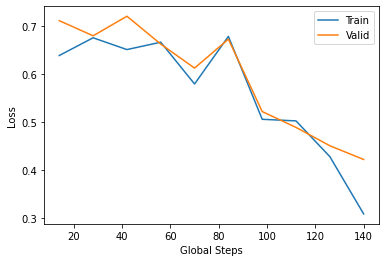

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

y_pred = []
y_true = []

best_model.eval()
with torch.no_grad():
    for (Label, Tweet), _ in test_loader:

            Label = Label.type(torch.LongTensor)           
            Label = Label.to(device)
            Tweet = Tweet.type(torch.LongTensor)  
            Tweet = Tweet.to(device)
            output = best_model(Tweet, Label)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(Label.tolist())

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

print("\n=========================================================\n")
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred, labels=[1,0])
print(cm)

print("\n=========================================================\n")
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy: {}".format(accuracy))

f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score: ", f1)

print("\n=========================================================\n")
print("Classification Report:")
print(classification_report(y_true, y_pred, labels=[1,0], digits=4, target_names=['Non-HS', 'HS']))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== .//model.pt


Confusion Matrix:
[[84  7]
 [12 40]]


Accuracy: 0.8671328671328671
F1 Score:  0.8532382650029708


Classification Report:
              precision    recall  f1-score   support

      Non-HS     0.8750    0.9231    0.8984        91
          HS     0.8511    0.7692    0.8081        52

    accuracy                         0.8671       143
   macro avg     0.8630    0.8462    0.8532       143
weighted avg     0.8663    0.8671    0.8656       143



# Penjelasan hasil training dan testing hate speech model 

untuk hasil dari training pada hate speech dataset menggunakan pre-trained model memiliki nilai akurasi dan recall yang baik yaitu akurasi sebesar 0.86 dan f1-score sebesar 0.85. Nilai ini juga dapat dilihat pada loss dan classification report diatas. untuk hasil dari plotting diatas dapat diketahui bahwa nilai loss dari model tersebut pada saat training maupun saat validasi menurun sejalan dengan bertambahnya global steps dan juga pada classification report yang menunjukkan nilai precision, recall, dan f1-score dari seriap labelnya memiliki niali yang baik juga, sebagai berikut:

1.   untuk data yang berupa non hate speech dengan jumlah data sebesar 91, model tersebut dapat memprediksinya dengan nilai precision sebesar 0.87, nilai recall sebesar 0.91, dan nilai f1-score sebesar 0.898.

2.   Untuk data yang berupa hate speech dengan jumlah data sebanyak 52 data, model tersebut dapat mehasilkan nilai precision sebesar 0.85, nilai recall sebesar 0.76, dan nilai f1-score sebesar 0.80.



# Test the model with Sentiment dataset

In [ ]:
# load dataset
dataset = pd.read_csv('sentiment.csv', sep=';')

text = dataset['Tweets']

dataset.head()

,Tweets,Label
0,rt @mrtampi: agus makin santai.\nahok makin sa...,negatif
1,pilkada dki jangan pilih pki!! berbahaya!! pil...,negatif
2,pdip sengaja becah belah rakyat warga dki tida...,negatif
3,rt @gunromli: sylviana kesyikan ngomong sendir...,negatif
4,rt @gunromli: sylviana kesyikan ngomong sendir...,negatif


## Pre-Processing the Sentiment Dataset

In [ ]:
def SentimentPreprocess(phrase):
    
    # Remove Indonesian stopwords
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()
    stop = stopword.remove(phrase)

    # Remove punctuation in the sentences and case-folding(lower all capital Latter)
    phrase = stop.translate(str.maketrans('','',string.punctuation)).lower()

    # remove number
    phrase = re.sub(r"\d+", "", phrase)

    #remove whitespace
    phrase = phrase.strip()
    
    return phrase

In [ ]:
new_txt = text.apply(SentimentPreprocess)

dataset['Tweets'] = new_txt.copy()
dataset['Label'] = (dataset['Label'] == 'positif').astype('int')

dataset.head()

,Tweets,Label
0,rt mrtampi agus makin santainahok makin santun...,0
1,pilkada dki jangan pilih pki berbahaya pilih ...,0
2,pdip sengaja becah belah rakyat warga dki pili...,0
3,rt gunromli sylviana kesyikan ngomong sendiri ...,0
4,rt gunromli sylviana kesyikan ngomong sendiri ...,0


In [ ]:
# Split according to label
df_negatif = dataset[dataset['Label'] == 0]
df_positif = dataset[dataset['Label'] == 1]

# Train-test split
df_negatif_full_train, df_negatif_test = train_test_split(df_negatif, train_size = 0.8, random_state = 1)
df_positif_full_train, df_positif_test = train_test_split(df_positif, train_size = 0.8, random_state = 1)

# Train-valid split
df_negatif_train, df_negatif_valid = train_test_split(df_negatif_full_train, train_size = 0.8, random_state = 1)
df_positif_train, df_positif_valid = train_test_split(df_positif_full_train, train_size = 0.8, random_state = 1)

# Concatenate splits of different labels
df_train = pd.concat([df_negatif_train, df_positif_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_negatif_valid, df_positif_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_negatif_test, df_positif_test], ignore_index=True, sort=False)

# Write preprocessed data
df_train.to_csv(destination_folder + '/trainSentiment.csv', index=False)
df_valid.to_csv(destination_folder + '/validSentiment.csv', index=False)
df_test.to_csv(destination_folder + '/testSentiment.csv', index=False)

## Tokenize and Load Splitted Sentiment Dataframe

In [ ]:
# Model parameter
MAX_SEQ_LEN = 128
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('Tweets', text_field), ('Label', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='trainSentiment.csv', validation='validSentiment.csv',
                                           test='testSentiment.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

trainSentiment_loader = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.Tweets),
                            device=device, train=True, sort=True, sort_within_batch=True)
validSentiment_loader = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.Tweets),
                            device=device, train=True, sort=True, sort_within_batch=True)
testSentiment_loader = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

## Test and Evaluate the speech model with sentiment dataset 

In [ ]:
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

y_pred = []
y_true = []

best_model.eval()
with torch.no_grad():
    for (Tweets, Label), _ in testSentiment_loader:

            Label = Label.type(torch.LongTensor)           
            Label = Label.to(device)
            Tweets = Tweets.type(torch.LongTensor)  
            Tweets = Tweets.to(device)
            output = best_model(Tweets, Label)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(Label.tolist())

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

print("\n=========================================================\n")
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred, labels=[1,0])
print(cm)

print("\n=========================================================\n")
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy: {}".format(accuracy))

f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score: ", f1)

print("\n=========================================================\n")
print("Classification Report:")
print(classification_report(y_true, y_pred, labels=[1,0], digits=4, target_names=['Positif', 'Negatif']))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== .//model.pt


Confusion Matrix:
[[148   4]
 [138  12]]


Accuracy: 0.5298013245033113
F1 Score:  0.41018870000550145


Classification Report:
              precision    recall  f1-score   support

     Positif     0.5175    0.9737    0.6758       152
     Negatif     0.7500    0.0800    0.1446       150

    accuracy                         0.5298       302
   macro avg     0.6337    0.5268    0.4102       302
weighted avg     0.6330    0.5298    0.4119       302



# Penjelasan hasil testing hate speech model dengan menggunakan sentiment dataset

untuk hasil dari testing diatas, dapat diketahui bahwa model tersebut dalam melakukan testing dengan sentiment dataset, memiliki nilai akurasi dan f1-score yang kurang baik untuk melakukan testing pada dataset sentiment. Nilai yang dihasilkan adalah akurasi sebesar 0.52 dan f1-score sebesar 0.41. Untuk perhitungan nilai precision, recall, dan f1-score untuk masing-masing label adalah sebagai berikut

1.   Untuk nilai precision dari data yang dengan label positif adalah 0.51, recall sebesar 0.97, dan f1-score sebesar 0.67 dari 152 data 

2.   Untuk nilai precision dari label negatif adalah 0.75, recall sebesar 0.08, dan f1 score sebesar 0.14 dari 150 data.






# Penjelasan Cross-Inferencing (Hate Speech trained BERT model --> test with sentiment dataset)

Untuk hasil dari cross-inferencing model dari pre-train BERT model yang di train menggunakan hate speech dataset dan di test menggunakan sentiment dataset dapat diketahui bahwa beberapa dari tweets yang tergolong hate speech cenderung mempunyai sentimen negatif dapat dibuktikan pada hasil dari classification report diatas yang dimana menurut model yang telah dilatih oleh hate speech dataset dan di test menggunakan sentiment dataset untuk yang menghasilkan nilai negatif memiliki nilai precision yang cukup besar yaitu 0.75 dan recall sebesar 0.80 yang dimana dari nilai tersebut dapat diketahui bahwa beberapa tweet yang tergolong hate speech termasuk kedalam sentiment negatif. 





# Referensi

1. https://github.com/wawancenggoro/COMP6567/tree/master/Session%2011

2. https://medium.com/@ksnugroho/dasar-text-preprocessing-dengan-python-a4fa52608ffe

3. https://huggingface.co/cahya/bert-base-indonesian-522M